# All or nothing pathfinders
1. Modify supply information in `sm.links` and `sm.road_links`
2. Run two possible all or nothing PT pathfinders:
    - one allowing walking on the road network
    - one allowing walking only on dedicated footpaths
3. Run on all or nothing road pathfinder

In [16]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [17]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.model import stepmodel
import os
import pandas as pd
if manual:
    %matplotlib inline

In [18]:
training_folder = '../../'

Load the model `base/walk_model.zip`.

In [19]:
sm = stepmodel.read_zip(training_folder + r'model/{scen}/walk_model.zip'.format(scen='base'))

read_hdf: 100%|████████████████████████████████████████████████████████████████████████| 27/27 [00:02<00:00, 11.65it/s]


# Additional supply data
- links length
- road_links time and walk_time

1. Compute the mean bus commercial speed from `sm.links` dataframe.
2. Set `road_links['time']` based on a `car_speed` 25% higher than bus commercial speed
3. Set `road_links['walk_time']` based on a walking speed three times slower than car.

In [33]:
# From the GTFS data, networkcasted on the road network,
# we get the bus mean commercial speed and use it to derive a mean car speed
sm.links['length'] = sm.links.length
bus = sm.links.loc[sm.links['route_type'] == 'bus']
bus_lines = bus.groupby('route_id')[['time', 'length']].sum()
bus_speed = bus['length'].sum() / bus['time'].sum() # operation speed
print('bus_speed =', round(bus_speed,1), 'm / s')

car_speed = bus_speed * 1.25

bus_speed = 4.2 m / s


In [35]:
# road
sm.road_links['time'] = sm.road_links['length'] / car_speed # m/s

# walk
sm.road_links['walk_time'] = sm.road_links['time'] * 3 # walk three times slower than car

# PT PATHFINDER
## walk on road
People walk on the road network, slow computation.  
Requires `'walk_time'` in `road_links` columns.

In [36]:
wor = sm.copy()
wor.step_pt_pathfinder(broken_modes=False, broken_routes=False, walk_on_road=True)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12100/12100 [00:00<00:00, 16777.14it/s]


## as the crow flies
people walk on dedicated access and egress links only

In [37]:
acf = sm.copy()
acf.step_pt_pathfinder(broken_modes=False, broken_routes=False)

path_analysis: 100%|██████████████████████████████████████████████████████████| 12100/12100 [00:00<00:00, 16359.72it/s]


For all OD, compare gtime obtained with acf and obtained with wor.
1. by plotting both on a scatter plot
2. by comparing their statistics

,gtime_wor,gtime_acf
count,11990.000000,11990.000000
mean,2027.648773,2043.793920
std,586.956897,585.975267
min,458.044967,512.266650
25%,1622.022537,1637.140636
50%,2034.714811,2049.480999
75%,2428.364776,2444.190238
max,4208.460032,4208.460032


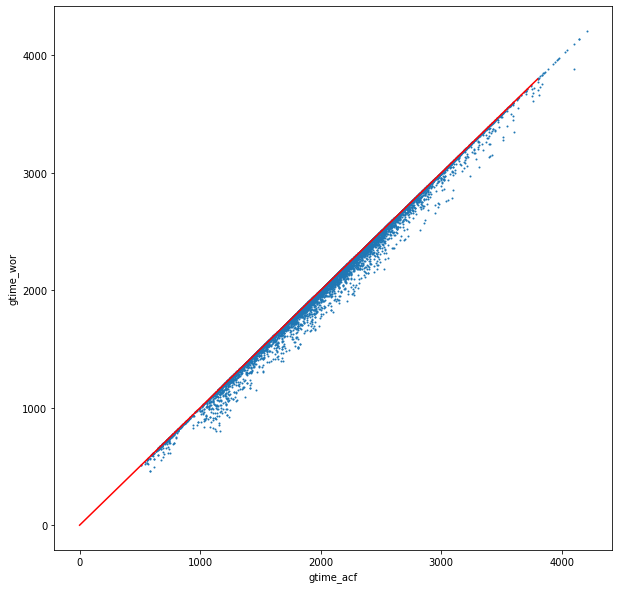

In [55]:
los = pd.merge(acf.pt_los, wor.pt_los, on=['origin', 'destination'], suffixes=('_acf', '_wor'))
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='gtime_acf', y='gtime_wor', figsize=[10, 10], s=1)
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(0,4000,200), np.arange(0,4000,200),color='r')
los[['gtime_wor', 'gtime_acf']].describe()

In [38]:
# here we chose to use the ACF paths only
sm.pt_los = acf.pt_los

# ROAD PATHFINDER

In [39]:
sm.step_road_pathfinder(all_or_nothing=True)

100%|████████████████████████████████████████████████████████████████████████████████| 110/110 [00:11<00:00,  9.77it/s]


In [11]:
if not os.path.isdir(training_folder + 'model/{scen}'.format(scen=scenario)):
    os.mkdir(training_folder + "model/%s" % scenario)
sm.to_zip(training_folder + 'model/{scen}/aon_pathfinder.zip'.format(scen=scenario))  

to_hdf(new file): 100%|████████████████████████████████████████████████████████████████| 38/38 [00:06<00:00,  5.44it/s]


# PLOT

Compare the PT and CAR level of service for all ODs.  

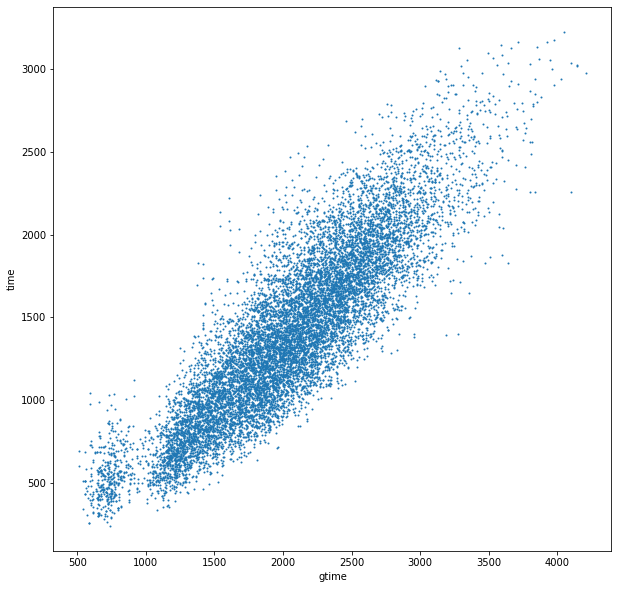

In [41]:
los = pd.merge(sm.pt_los, sm.car_los, on=['origin', 'destination'])
los = los.loc[los['origin'] != los['destination']]
los.plot(kind='scatter', x='gtime', y='time', figsize=[10, 10], s=1)

# END